In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import warnings
warnings.filterwarnings(action="ignore")

# Questions 

Exploratory warm-up:
1. Which product have the greatest prospect-to-customer ratio?

2. Which product have the greatest challenge with retention in the first 3 months of product use? Do you think the 3 month retention rates vary significantly across different product?

Meat of the problem:

3. We have a repertoire of tactics we can deploy to keep customers happy and engaged, but would like to be smart about who to target with what tactics when. Stakeholders in the customer care and marketing department come to you, asking for guidance. Can you slice and dice the data, with this question in mind, to uncover meaningful insights on the customer retention behavior, and make actionable recommendations accordingly? 

# 1. Load Data 

In [2]:
customers = pd.read_csv('customers.csv')
quiz = pd.read_csv('quiz_sessions.csv') 

In [3]:
customers.head(5)

,customer_id,product_name,journey_length,currently_customer,customer age group at the point of sign up
0,445,product11,185.0,N,under 18
1,2831,product5,965.0,N,25-35
2,2834,product11,1032.0,N,25-35
3,2855,product5,8.0,N,25-35
4,2885,product5,45.0,N,25-35


In [4]:
quiz.head(5)

,customer_id,product_name,answer1,answer2,answer3,answer4,answer5,answer6,answer7,answer8,...,answer18,answer19,answer20,answer21,answer22,answer23,answer24,answer25,log_total_time,device
0,56006,product4,3.0,2,2.0,2,6,1.0,3.0,1.0,...,1.0,1.0,2.0,3.0,1.0,3.0,3.0,1.0,8.038644,NaN
1,56088,product4,4.0,1,1.0,5,3,1.0,1.0,4.0,...,1.0,1.0,4.0,1.0,1.0,4.0,4.0,1.0,7.294608,NaN
2,56107,product4,3.0,1,2.0,2,0,1.0,3.0,1.0,...,1.0,1.0,3.0,3.0,1.0,1.0,3.0,1.0,7.825903,NaN
3,56110,product4,4.0,3,1.0,1,0,1.0,3.0,1.0,...,3.0,3.0,3.0,1.0,1.0,3.0,3.0,1.0,7.326702,NaN
4,56162,product4,4.0,4,2.0,0,0,1.0,4.0,3.0,...,1.0,3.0,1.0,4.0,3.0,3.0,1.0,4.0,7.828100,NaN


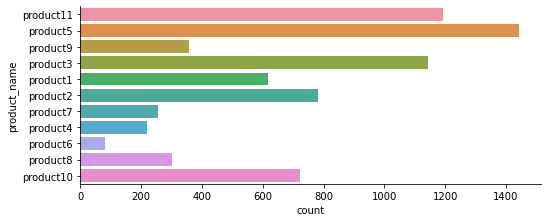

In [5]:
# total users per product
ax = sns.catplot(y="product_name", kind="count", data=customers, height=3, aspect=2.5, orient='h')

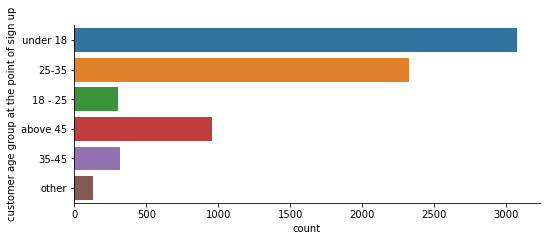

In [6]:
# num of users by age groups
ax = sns.catplot(y="customer age group at the point of sign up", kind="count", data=customers, height=3, aspect=2.5, orient='h')

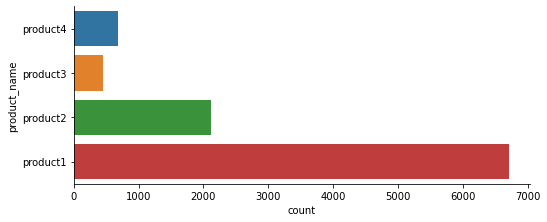

In [7]:
# num of quiz users by product
ax = sns.catplot(y="product_name", kind="count", data=quiz, height=3, aspect=2.5, orient='h')

In [8]:
# Check for quiz length
quiz['log_total_time'].describe()

count    9953.000000
mean        8.159644
std         1.313274
min         5.943985
25%         7.524984
50%         7.810997
75%         8.196088
max        18.208141
Name: log_total_time, dtype: float64

# 2. Exploratory Data Analysis
## 2.1 Which product have the greatest prospect-to-customer ratio?

**Answer**
- product1 has the greatest prospect-to-customer ratio of 10.9%

In [9]:
quiz_n_by_product = quiz.groupby('product_name')['customer_id'].nunique().reset_index(drop=False)\
                        .rename(columns={'customer_id': 'customer_cnt'}, inplace=False)

In [10]:
quiz_n_by_product

,product_name,customer_cnt
0,product1,6701
1,product2,2123
2,product3,453
3,product4,676


In [11]:
customer_n_by_product = customers.groupby('product_name')['customer_id'].nunique().reset_index(drop=False)\
                                 .rename(columns={'customer_id': 'customer_cnt'}, inplace=False)

In [12]:
customer_n_by_product.sort_values(by=['customer_cnt'], inplace=True, ascending=False)

In [13]:
customer_n_by_product

,product_name,customer_cnt
6,product5,1441
2,product11,1194
4,product3,1142
3,product2,782
1,product10,723
0,product1,617
10,product9,358
9,product8,303
8,product7,255
5,product4,220


In [14]:
merged_df = pd.merge(quiz_n_by_product, customer_n_by_product, on='product_name')

In [15]:
merged_df = merged_df.rename(columns={'customer_cnt_x':'user_cnt_quiz','customer_cnt_y': 'user_cnt'})

In [16]:
merged_df['quiz_to_user_ratio'] = merged_df['user_cnt_quiz']/merged_df['user_cnt']

In [17]:
merged_df.sort_values(by=['quiz_to_user_ratio'], ascending=False)

,product_name,user_cnt_quiz,user_cnt,quiz_to_user_ratio
0,product1,6701,617,10.860616
3,product4,676,220,3.072727
1,product2,2123,782,2.714834
2,product3,453,1142,0.396673


## 2.2 Which product have the greatest challenge with retention in the first 3 months of product use? Do you think the 3 month retention rates vary significantly across different product?


**Answer**
- product2 has the greatest challenge with retention in the first 3 month
- 3 month retention rate across products has a standard deviation of 0.056, and an average of ~12%, which indicates it fluctuates +-5.6% from the mean. 

In [18]:
def get_retention(df, group, value, sort_by=None, asc=True):
    df['total_users'] = df.sort_values(by=sort_by, ascending=asc).groupby(group)[value].transform('sum')
    df['%_of_total'] = round(df['customer_cnt'] / df['total_users'],2)
    df['sum_3_month']= df[df['journey_length_month']<=3]\
                        .sort_values(by=sort_by,ascending=asc)\
                        .groupby(group)[value].transform('sum')
    df['sum_6_month']= df[df['journey_length_month']<=6]\
                        .sort_values(by=sort_by,ascending=asc)\
                        .groupby(group)[value].transform('sum')
    df['sum_12_month']= df[df['journey_length_month']<=12]\
                        .sort_values(by=sort_by,ascending=asc)\
                        .groupby(group)[value].transform('sum')
    df['% churned within 3 month'] = round(df['sum_3_month']/df['total_users'],2)
    df['% churned within 6 month'] = round(df['sum_6_month']/df['total_users'],2)
    df['% churned within 12 month'] = round(df['sum_12_month']/df['total_users'],2)

In [19]:
# convert journey_length to month, 1 month = 30 days
customers['journey_length_month'] = round(customers['journey_length'] / 30,0)
customers.head()

,customer_id,product_name,journey_length,currently_customer,customer age group at the point of sign up,journey_length_month
0,445,product11,185.0,N,under 18,6.0
1,2831,product5,965.0,N,25-35,32.0
2,2834,product11,1032.0,N,25-35,34.0
3,2855,product5,8.0,N,25-35,0.0
4,2885,product5,45.0,N,25-35,2.0


In [20]:
month_cohort = customers.groupby(['journey_length_month', 'product_name'])['customer_id']\
                        .nunique().reset_index(drop=False).rename(columns={'customer_id': 'customer_cnt'}, inplace=False)

In [21]:
get_retention(month_cohort, group=['product_name'], 
        value='customer_cnt', sort_by=['product_name','journey_length_month'])

In [22]:
# Overall Churn Statistics
month_cohort[(month_cohort['journey_length_month'] == 3)].sort_values(by=['% churned within 3 month'],ascending=False)\
                                                        .drop(columns=['journey_length_month', 'customer_cnt','%_of_total'])

,product_name,total_users,sum_3_month,sum_6_month,sum_12_month,% churned within 3 month,% churned within 6 month,% churned within 12 month
36,product2,772,166.0,294.0,504.0,0.22,0.38,0.65
38,product4,219,42.0,57.0,117.0,0.19,0.26,0.53
33,product1,609,99.0,137.0,264.0,0.16,0.22,0.43
39,product5,1440,213.0,288.0,536.0,0.15,0.20,0.37
41,product7,254,33.0,51.0,108.0,0.13,0.20,0.43
35,product11,1184,130.0,220.0,394.0,0.11,0.19,0.33
40,product6,81,7.0,15.0,39.0,0.09,0.19,0.48
34,product10,721,44.0,95.0,192.0,0.06,0.13,0.27
37,product3,1137,72.0,159.0,360.0,0.06,0.14,0.32
43,product9,356,22.0,70.0,164.0,0.06,0.20,0.46


In [23]:
print("3 Month Churn - Mean: %f" %month_cohort['% churned within 3 month'].mean() , "Standard Deviation: %f" %month_cohort['% churned within 3 month'].std())
print("6 Month Churn - Mean: %f" %month_cohort['% churned within 6 month'].mean() , "Standard Deviation: %f" %month_cohort['% churned within 6 month'].std())
print("12 Month Churn - Mean: %f" %month_cohort['% churned within 12 month'].mean() , "Standard Deviation: %f" %month_cohort['% churned within 12 month'].std())

3 Month Churn - Mean: 0.116364 Standard Deviation: 0.056284
6 Month Churn - Mean: 0.218182 Standard Deviation: 0.067565
12 Month Churn - Mean: 0.441818 Standard Deviation: 0.112059


## Current User Y/N 

In [24]:
# Current User Churn Statistics
month_cohort2_current = customers.groupby(['journey_length_month', 'product_name', 'currently_customer'])['customer_id']\
                        .nunique().reset_index(drop=False)\
                        .rename(columns={'customer_id': 'customer_cnt'}, inplace=False)

In [25]:
get_retention(month_cohort2_current, group=['product_name','currently_customer'], 
        value='customer_cnt', sort_by=['product_name','journey_length_month'])

In [26]:
month_cohort2_current\
    [(month_cohort2_current['journey_length_month']==0) & (month_cohort2_current['currently_customer']=='Y')]\
    .sort_values('% churned within 3 month', ascending=False).drop(columns=['journey_length_month','customer_cnt','%_of_total'])

,product_name,currently_customer,total_users,sum_3_month,sum_6_month,sum_12_month,% churned within 3 month,% churned within 6 month,% churned within 12 month
7,product2,Y,124,37.0,56.0,93.0,0.30,0.45,0.75
11,product4,Y,32,5.0,8.0,13.0,0.16,0.25,0.41
13,product5,Y,222,36.0,50.0,76.0,0.16,0.23,0.34
17,product7,Y,40,6.0,9.0,15.0,0.15,0.22,0.38
1,product1,Y,85,11.0,15.0,34.0,0.13,0.18,0.40
5,product11,Y,185,20.0,33.0,66.0,0.11,0.18,0.36
15,product6,Y,9,1.0,2.0,5.0,0.11,0.22,0.56
3,product10,Y,117,7.0,17.0,30.0,0.06,0.15,0.26
9,product3,Y,163,10.0,24.0,42.0,0.06,0.15,0.26


In [27]:
print("3 Month Churn - Mean: %f" %month_cohort2_current['% churned within 3 month'].mean() , "Standard Deviation: %f" %month_cohort2_current['% churned within 3 month'].std())
print("6 Month Churn - Mean: %f" %month_cohort2_current['% churned within 6 month'].mean() , "Standard Deviation: %f" %month_cohort2_current['% churned within 6 month'].std())
print("12 Month Churn - Mean: %f" %month_cohort2_current['% churned within 12 month'].mean() , "Standard Deviation: %f" %month_cohort2_current['% churned within 12 month'].std())

3 Month Churn - Mean: 0.126447 Standard Deviation: 0.063492
6 Month Churn - Mean: 0.223015 Standard Deviation: 0.079212
12 Month Churn - Mean: 0.431535 Standard Deviation: 0.127879


## 3. We have a repertoire of tactics we can deploy to keep customers happy and engaged, but would like to be smart about who to target with what tactics when. Stakeholders in the customer care and marketing department come to you, asking for guidance. Can you slice and dice the data, with this question in mind, to uncover meaningful insights on the customer retention behavior, and make actionable recommendations accordingly?

In [28]:
month_cohort2_age = customers.groupby(['journey_length_month', 'product_name', 'customer age group at the point of sign up'])['customer_id']\
                        .nunique().reset_index(drop=False)\
                        .rename(columns={'customer_id': 'customer_cnt'}, inplace=False)

In [30]:
get_retention(month_cohort2_age, group=['product_name','customer age group at the point of sign up'], 
        value='customer_cnt', sort_by=['product_name','journey_length_month'])

In [32]:
age_group_by_product = month_cohort2_age[(month_cohort2_age['journey_length_month']==0)].drop(columns=['journey_length_month', 'customer_cnt','%_of_total'])
age_group_by_product.sort_values(by=['customer age group at the point of sign up'], ascending=False)

,product_name,customer age group at the point of sign up,total_users,sum_3_month,sum_6_month,sum_12_month,% churned within 3 month,% churned within 6 month,% churned within 12 month
2,product1,under 18,270,30.0,49.0,102.0,0.11,0.18,0.38
29,product8,under 18,276,14.0,85.0,169.0,0.05,0.31,0.61
28,product7,under 18,106,11.0,19.0,31.0,0.10,0.18,0.29
5,product10,under 18,289,13.0,54.0,99.0,0.04,0.19,0.34
23,product5,under 18,316,37.0,59.0,89.0,0.12,0.19,0.28
10,product11,under 18,600,54.0,96.0,200.0,0.09,0.16,0.33
17,product3,under 18,608,41.0,64.0,171.0,0.07,0.11,0.28
13,product2,under 18,385,108.0,156.0,293.0,0.28,0.41,0.76
16,product3,other,60,5.0,7.0,12.0,0.08,0.12,0.20
25,product6,other,12,2.0,5.0,8.0,0.17,0.42,0.67


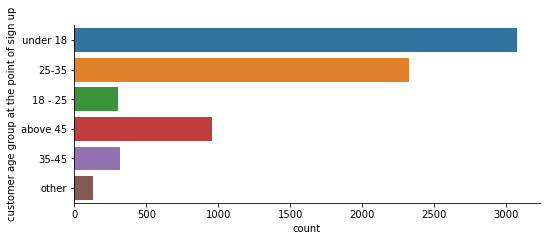

In [33]:
# num of users by age groups
ax = sns.catplot(y="customer age group at the point of sign up", kind="count", data=customers, height=3, aspect=2.5, orient='h')

In [34]:
age_groups = {}
for i in list(age_group_by_product['customer age group at the point of sign up'].unique()):
    print(i)
    age_groups[i] = age_group_by_product[age_group_by_product['customer age group at the point of sign up'] == i]

25-35
above 45
under 18
18 - 25
35-45
other


## 3.1 Age Groups

### TLDR

Cohorts that needs attention:
- [under 18] product2 and product8
- [18 - 25] no immediate attention required
- [25 - 35] product6
- [35 - 45] no immediate attention required
- [above 45] product1 and product4

### Under 18

- The majority age group is 'under 18', which is associated with 8 product groups with the absence of product4，product6 and product9.
- **product2** has the highest churn rate for all 3 time ranges, with a 12 month churn rate of 76%.
- While a median 12 month churn rate of ~33.5%, **product2 and product8** is associated with above average 12M churn, which we believe needs attention. 

In [35]:
# used median here given outliers
age_groups['under 18']['% churned within 12 month'].median()

0.335

In [36]:
age_groups['under 18'].sort_values(by=['% churned within 12 month'], ascending=False)

,product_name,customer age group at the point of sign up,total_users,sum_3_month,sum_6_month,sum_12_month,% churned within 3 month,% churned within 6 month,% churned within 12 month
13,product2,under 18,385,108.0,156.0,293.0,0.28,0.41,0.76
29,product8,under 18,276,14.0,85.0,169.0,0.05,0.31,0.61
2,product1,under 18,270,30.0,49.0,102.0,0.11,0.18,0.38
5,product10,under 18,289,13.0,54.0,99.0,0.04,0.19,0.34
10,product11,under 18,600,54.0,96.0,200.0,0.09,0.16,0.33
28,product7,under 18,106,11.0,19.0,31.0,0.10,0.18,0.29
17,product3,under 18,608,41.0,64.0,171.0,0.07,0.11,0.28
23,product5,under 18,316,37.0,59.0,89.0,0.12,0.19,0.28


### 18 - 25

- In age group '18-25', only two products contains record. Among them, **product7** has a much higher 12 month churn rate of 51% comparing to product 11 with a 22% churn. 
- 3 Month and 6 month churn on the other hand remained relatively stable.

In [37]:
age_groups['18 - 25']

,product_name,customer age group at the point of sign up,total_users,sum_3_month,sum_6_month,sum_12_month,% churned within 3 month,% churned within 6 month,% churned within 12 month
6,product11,18 - 25,59,6.0,10.0,13.0,0.10,0.17,0.22
26,product7,18 - 25,41,5.0,8.0,21.0,0.12,0.20,0.51


### 25 - 35 

- This is the second largest age group with 9 products associated with it. No presence of product7 and product8.
- With an average 12M churn of ~41%, **product6 and product4** stands out with 71% and 53% churn rate, needs to be addressed

In [38]:
age_groups['25-35']['% churned within 12 month'].mean()

0.4111111111111111

In [39]:
age_groups['25-35'].sort_values(by=['% churned within 12 month'], ascending=False)

,product_name,customer age group at the point of sign up,total_users,sum_3_month,sum_6_month,sum_12_month,% churned within 3 month,% churned within 6 month,% churned within 12 month
24,product6,25-35,21,3.0,6.0,15.0,0.14,0.29,0.71
18,product4,25-35,122,24.0,30.0,65.0,0.20,0.25,0.53
11,product2,25-35,197,25.0,54.0,97.0,0.13,0.27,0.49
30,product9,25-35,163,12.0,35.0,69.0,0.07,0.21,0.42
14,product3,25-35,312,14.0,63.0,128.0,0.04,0.20,0.41
20,product5,25-35,779,130.0,169.0,301.0,0.17,0.22,0.39
0,product1,25-35,158,12.0,22.0,49.0,0.08,0.14,0.31
7,product11,25-35,359,39.0,64.0,106.0,0.11,0.18,0.30
3,product10,25-35,168,9.0,12.0,24.0,0.05,0.07,0.14


### 35 - 45 

- Small sample size for product5, will disregard.
- product11 and product7 are on the same magnitude in terms of 12M churn, which is slightly higher than 40% but manageable. 

In [40]:
age_groups['35-45']

,product_name,customer age group at the point of sign up,total_users,sum_3_month,sum_6_month,sum_12_month,% churned within 3 month,% churned within 6 month,% churned within 12 month
8,product11,35-45,84,21.0,34.0,47.0,0.25,0.40,0.56
21,product5,35-45,2,1.0,1.0,2.0,0.50,0.50,1.00
27,product7,35-45,59,14.0,18.0,38.0,0.24,0.31,0.64


### above 45

- This is the 3rd largest age group, with 7 products associated with it.
- **product1 and product4** are the outlier in the group with a 77% and 74% 12M churn rate while group median is 40% and mean is 47%

In [41]:
age_groups['above 45']['% churned within 12 month'].median()

0.4

In [42]:
age_groups['above 45']['% churned within 12 month'].mean()

0.47285714285714286

In [43]:
age_groups['above 45'].sort_values(by=['% churned within 12 month'], ascending=False)

,product_name,customer age group at the point of sign up,total_users,sum_3_month,sum_6_month,sum_12_month,% churned within 3 month,% churned within 6 month,% churned within 12 month
1,product1,above 45,123,51.0,55.0,95.0,0.41,0.45,0.77
19,product4,above 45,31,11.0,15.0,22.0,0.35,0.48,0.71
22,product5,above 45,340,45.0,59.0,141.0,0.13,0.17,0.41
31,product9,above 45,48,2.0,5.0,19.0,0.04,0.10,0.40
15,product3,above 45,95,10.0,21.0,35.0,0.11,0.22,0.37
9,product11,above 45,79,10.0,15.0,27.0,0.13,0.19,0.34
4,product10,above 45,67,7.0,9.0,21.0,0.10,0.13,0.31


### other

- product3 seem to be missing out on quite a few age group info which is bucketed as 'other'

In [44]:
age_groups['other']

,product_name,customer age group at the point of sign up,total_users,sum_3_month,sum_6_month,sum_12_month,% churned within 3 month,% churned within 6 month,% churned within 12 month
12,product2,other,7,1.0,1.0,2.0,0.14,0.14,0.29
16,product3,other,60,5.0,7.0,12.0,0.08,0.12,0.20
25,product6,other,12,2.0,5.0,8.0,0.17,0.42,0.67


# Closing

In summary, to keep customers engaged and better the retention for products
- Target customers by product and age group, prioritize on high churing cohorts.
- While products 2,8,6,1,4 are all facing rentetion challenges in different age groups, should prioritize on products that have a larger user base such as 1 and 2.

This report is based on pre-exsisting data and might be biased due to coll